In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns
import copy

import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
df_bnb = read_root('../data/bnb_overlay/FVV-Prime-bnb-Mar3-WC-1M1P.root')
df_bnb_truth = read_root('../data/bnb_overlay/mcc9_v28_wctagger_bnboverlay_truthscrape.root')
df_bnb_cvweight = read_root('../data/bnb_overlay/weights_forCV_v40_bnb_nu_run1.root')

In [3]:
RSE = ['run','subrun','event']
df_bnb_full = df_bnb_truth.join(df_bnb.set_index(RSE),on=RSE,lsuffix='_troof').query('True1L1P==1 and Contained==1')
df_bnb_full = df_bnb_full.join(df_bnb_cvweight.set_index(RSE)[['xsec_corr_weight','spline_weight']],on=RSE)

(array([   0., 2684., 7136., 8866., 8446., 7317., 6452., 5701., 4735.,
        3986., 3342., 2579., 1998., 1491., 1169.,  877.,  647.,  459.,
         409.,  302.,  232.,  210.,  121.,  157.,  124.,  125.,  104.,
         104.,  122.,  113.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000.], dtype=float32),
 <a list of 30 Patch objects>)

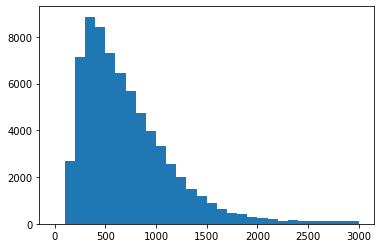

In [5]:
plt.hist(df_bnb_full['mc_muon_Edep'].values,30,(0,3000))


In [4]:
# Let's kill some dupes
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_apr1.pickle','rb') as handle: cosmicBDT,nubkgBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
    
vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']

myvars = vars_cos_allofem
s_nubdtname = 'NuBkgScore'
s_cosbdtname = 'CosmicBkgScore'

In [5]:
df_bnb_full.insert(0,s_nubdtname,nubkgBDT.predict(df_bnb_full[myvars].values.tolist(),output_margin=True))
df_bnb_full.insert(0,s_cosbdtname,cosmicBDT.predict(df_bnb_full[myvars].values.tolist(),output_margin=True))

df_bnb_nodupes = df_bnb_full.sort_values('CosmicBkgScore',ascending=False).drop_duplicates(['run','subrun','event']).sort_index()

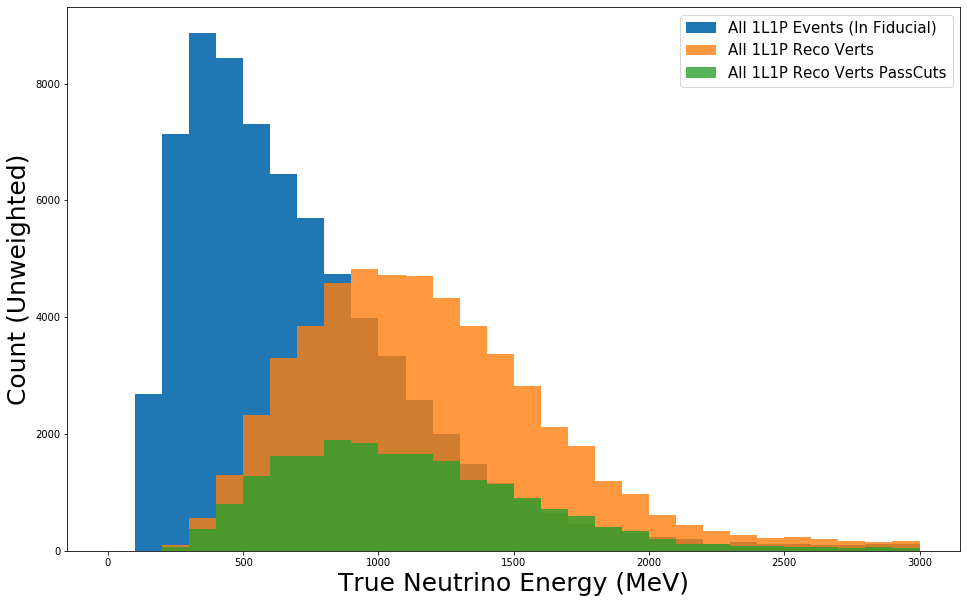

In [6]:
fig,ax = plt.subplots(figsize=(16,10))
plt.hist(df_bnb_full['mc_muon_Edep'].values,30,(0,3000),label='All 1L1P Events (In Fiducial)')
plt.hist(df_bnb_full.query('PassSimpleCuts > -999')['mc_energyInit'].values,30,(0,3000),label='All 1L1P Reco Verts',alpha=.8)
plt.hist(df_bnb_full.query('PassSimpleCuts==1')['mc_energyInit'].values,30,(0,3000),label='All 1L1P Reco Verts PassCuts',alpha=.8)
ax.set_xlabel('True Neutrino Energy (MeV)',fontsize=25)
ax.set_ylabel('Count (Unweighted)',fontsize=25)
#plt.yscale('linear')

ax.legend(fontsize = 15)

In [85]:
max(df_bnb_full['mc_Q3'].values)

4148.977

totalevents 231
vertreco 91
dupereco 80
passprecuts 39
passcosmic 2
passall 0


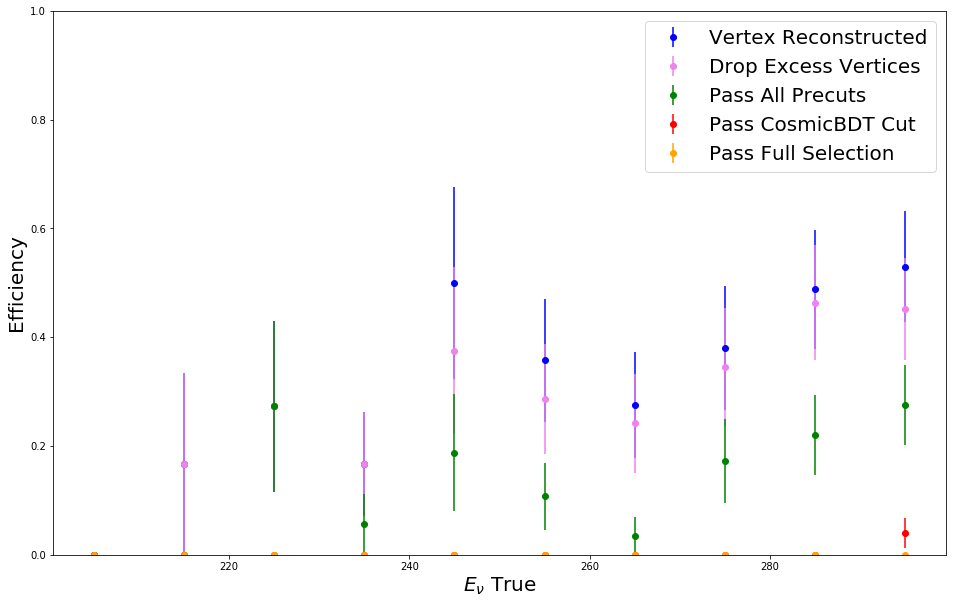

In [11]:
nbins = 10
myrange=(200,300)
vartest = 'mc_energyInit'

orthogonalcut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
coscut = 'CosBkgScore > 0'
nucut = 'NuBkgScore > 0'

#varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
#varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
#varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))


val_total,binedges = np.histogram(df_bnb_full.query('True1L1P==1 and Contained==1')[vartest].values,bins=nbins,range=myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]
print('totalevents',val_total.sum())

fig,ax = plt.subplots(figsize=(16,10))

val0_cut,_ = np.histogram(df_bnb_full.query('PassSimpleCuts > -999')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val0_cut,val_total),label='Vertex Reconstructed',yerr=np.sqrt(val0_cut)/val_total,fmt='o',c='blue')
print('vertreco',val0_cut.sum())

val1_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts > -999')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val1_cut,val_total),label='Drop Excess Vertices',yerr=np.sqrt(val1_cut)/val_total,fmt='o',c='violet')
print('dupereco',val1_cut.sum())

val2_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val2_cut,val_total),label='Pass All Precuts',yerr=np.sqrt(val2_cut)/val_total,fmt='o',c='green')
print('passprecuts',val2_cut.sum())

val3_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val3_cut,val_total),label='Pass CosmicBDT Cut',yerr=np.sqrt(val3_cut)/val_total,fmt='o',c='red')
print('passcosmic',val3_cut.sum())

val4_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0 and NuBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val4_cut,val_total),label='Pass Full Selection',yerr=np.sqrt(val4_cut)/val_total,fmt='o',c='orange')
print('passall',val4_cut.sum())

ax.set_ylim(0,1)
    
ax.set_xlabel(r'$E_\nu$ True',fontsize=20)
ax.set_ylabel('Efficiency',fontsize=20)
ax.legend(fontsize=20)

In [102]:
df_bnb_ccqe = df_bnb_full.query('mc_interactiontype == 1001.0 and NeutrinoPDG==14')
df_bnb_nodupes_ccqe = df_bnb_nodupes.query('mc_interactiontype == 1001.0 and NeutrinoPDG==14')

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


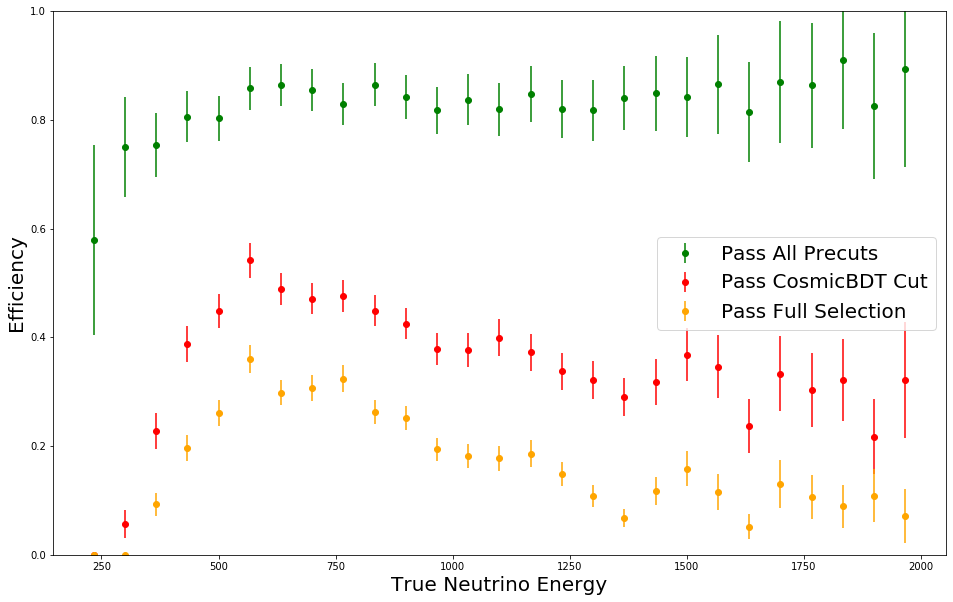

In [104]:
nbins = 30
myrange=(0,2000)
vartest = 'mc_energyInit'

orthogonalcut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
coscut = 'CosBkgScore > 0'
nucut = 'NuBkgScore > 0'

#varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
#varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
#varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))


val_total,binedges = np.histogram(df_bnb_nodupes_ccqe.query('PassSimpleCuts == 1')[vartest].values,bins=nbins,range=myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]

fig,ax = plt.subplots(figsize=(16,10))

#val1_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1')[vartest].values,bins=nbins,range=myrange)
#ax.errorbar(bincenters,np.divide(val1_cut,val_total),label='PassSimple',yerr=np.sqrt(val1_cut)/val_total,fmt='o',c='orange')

val2_cut,_ = np.histogram(df_bnb_nodupes_ccqe.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val2_cut,val_total),label='Pass All Precuts',yerr=np.sqrt(val2_cut)/val_total,fmt='o',c='green')
    
val3_cut,_ = np.histogram(df_bnb_nodupes_ccqe.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val3_cut,val_total),label='Pass CosmicBDT Cut',yerr=np.sqrt(val3_cut)/val_total,fmt='o',c='red')

val4_cut,_ = np.histogram(df_bnb_nodupes_ccqe.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0 and NuBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val4_cut,val_total),label='Pass Full Selection',yerr=np.sqrt(val4_cut)/val_total,fmt='o',c='orange')


ax.set_ylim(0,1)
    
ax.set_xlabel(r'True Neutrino Energy',fontsize=20)
ax.set_ylabel('Efficiency',fontsize=20)
ax.legend(fontsize=20)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


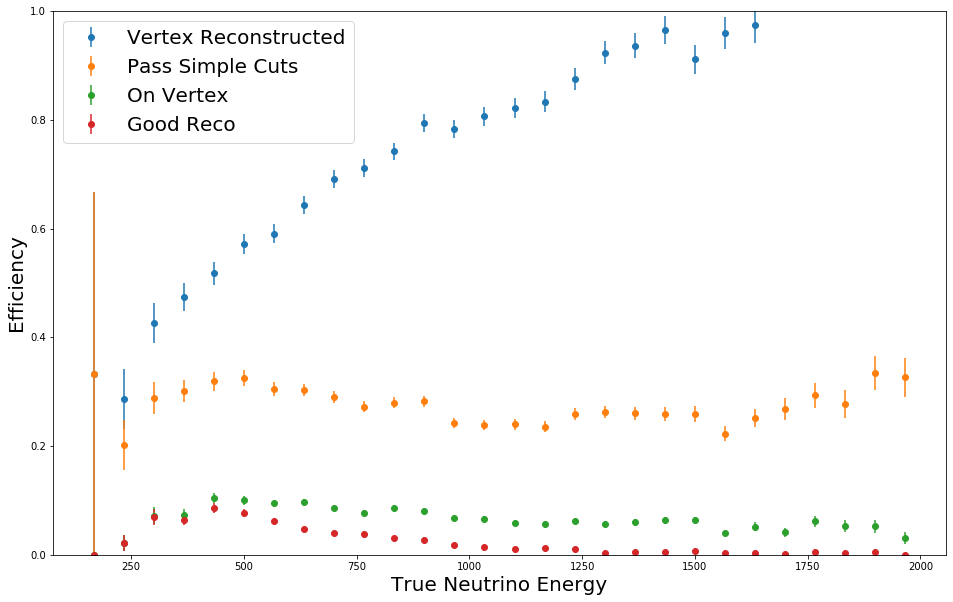

In [108]:
nbins = 30
myrange=(0,2000)
vartest = 'mc_energyInit'

orthogonalcut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
coscut = 'CosBkgScore > 0'
nucut = 'NuBkgScore > 0'

val_total,binedges = np.histogram(df_bnb_ccqe[vartest].values,bins=nbins,range=myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]

fig,ax = plt.subplots(figsize=(16,10))

val0_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts > -999')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val0_cut,val_total),label='Vertex Reconstructed',yerr=np.sqrt(val0_cut)/val_total,fmt='o')

val1_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val1_cut,val_total),label='Pass Simple Cuts',yerr=np.sqrt(val1_cut)/val_total,fmt='o')

val2_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1 and MC_scedr <= .5')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val2_cut,val_total),label='On Vertex',yerr=np.sqrt(val2_cut)/val_total,fmt='o')

val3_cut,_ = np.histogram(df_bnb_nodupes.query('PassSimpleCuts == 1 and MC_scedr <= .5 and abs(Enu_1m1p-MC_energyInit)/MC_energyInit < .2')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val3_cut,val_total),label='Good Reco',yerr=np.sqrt(val3_cut)/val_total,fmt='o')



#if not (row['MC_nproton']==1 and row['MC_nlepton']==1):
#        return 'nLmP'
#    elif not 0 < row['MC_scedr'] <= 5.0:
#        return 'offvtx'
#    elif not abs((row['MC_energyInit']-row['Enu_1m1p'])/row['MC_energyInit']) < 0.2:
#        return 'badreco'    
#    else:

ax.set_ylim(0,1)
    
ax.set_xlabel(r'True Neutrino Energy',fontsize=20)
ax.set_ylabel('Efficiency',fontsize=20)
ax.legend(fontsize=20)

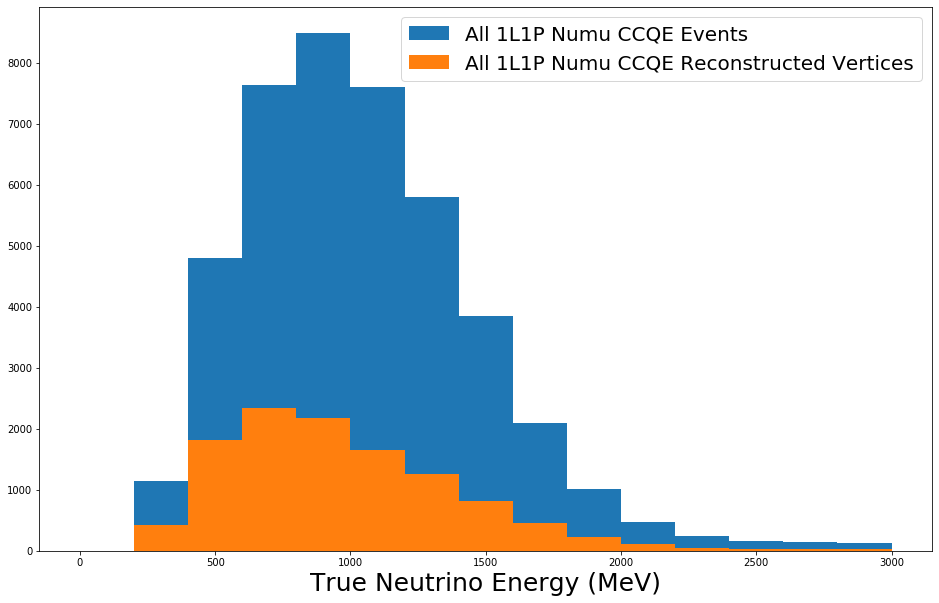

In [55]:
fig,ax = plt.subplots(figsize=(16,10))
plt.hist(df_bnb_ccqe['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Events')
plt.hist(df_bnb_ccqe.query('Enu_1m1p > 0')['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Reconstructed Vertices')
ax.set_xlabel('True Neutrino Energy (MeV)',fontsize=25)

ax.legend(fontsize = 20)

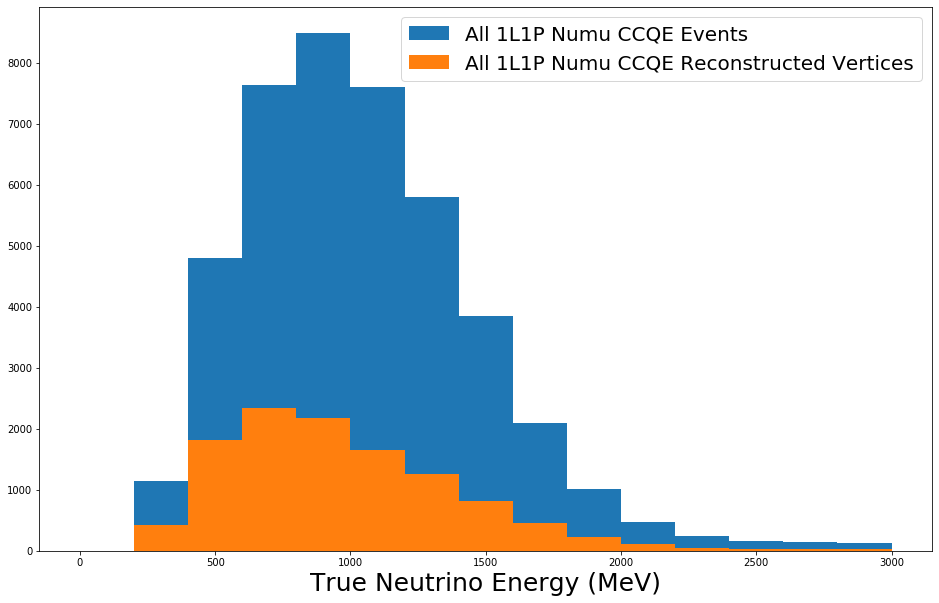

In [55]:
fig,ax = plt.subplots(figsize=(16,10))
plt.hist(df_bnb_ccqe['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Events')
plt.hist(df_bnb_ccqe.query('Enu_1m1p > 0')['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Reconstructed Vertices')
ax.set_xlabel('True Neutrino Energy (MeV)',fontsize=25)

ax.legend(fontsize = 20)

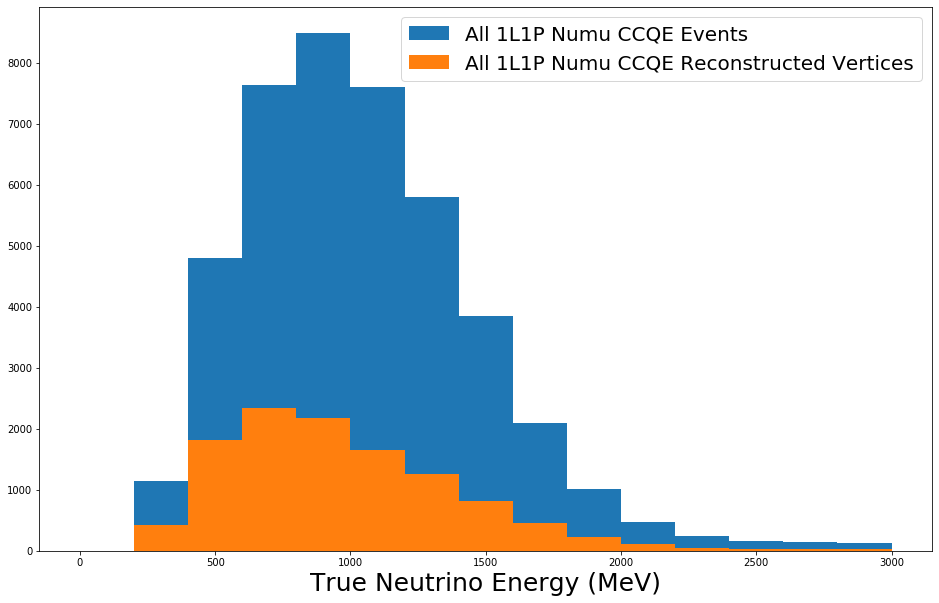

In [55]:
fig,ax = plt.subplots(figsize=(16,10))
plt.hist(df_bnb_ccqe['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Events')
plt.hist(df_bnb_ccqe.query('Enu_1m1p > 0')['mc_energyInit'].values,15,(0,3000),label='All 1L1P Numu CCQE Reconstructed Vertices')
ax.set_xlabel('True Neutrino Energy (MeV)',fontsize=25)

ax.legend(fontsize = 20)